In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import numpy as np
import tempfile
import tensorflow as tf

from tf_rl.controller import DiscreteDeepQ, HumanController
from tf_rl import simulate
from tf_rl.models import MLP
from maddux.rl_experiments.simple_reward_planning import SimpleRewardPlanning, Planning
from maddux.rl_experiments.environments import get_easy_environment, get_hard_environment, get_very_hard_environment

In [4]:
LOG_DIR = tempfile.mkdtemp()
print(LOG_DIR)

/tmp/tmpSFCSmJ


In [5]:
SAVE_DIR = "/home/colin/robots/maddux/saved_experiments"

In [13]:
#game = SimpleRewardPlanning(get_easy_environment())
game = Planning(get_easy_environment())

In [14]:
# Tensorflow business - it is always good to reset a graph before creating a new controller.
tf.reset_default_graph()
session = tf.InteractiveSession()

# This little guy will let us run tensorboard
#      tensorboard --logdir [LOG_DIR]
journalist = tf.train.SummaryWriter(LOG_DIR)

# Brain maps from observation to Q values for different actions.
# Here it is a done using a multi layer perceptron with 2 hidden
# layers
brain = MLP([game.observation_size,], [200, 200, game.num_actions], 
            [tf.tanh, tf.tanh, tf.identity])

# The optimizer to use. Here we use RMSProp as recommended
# by the publication
optimizer = tf.train.RMSPropOptimizer(learning_rate= 0.001, decay=0.9)

# DiscreteDeepQ object
current_controller = DiscreteDeepQ(game.observation_size, game.num_actions, brain, 
                                   optimizer, session, random_action_probability=0.1,
                                   discount_rate=0.99, exploration_period=1000, 
                                   max_experience=10000, store_every_nth=1, 
                                   train_every_nth=1, summary_writer=journalist)

session.run(tf.initialize_all_variables())
session.run(current_controller.target_network_update)
# graph was not available when journalist was created  
journalist.add_graph(session.graph)

game_idx = 0

Exception AssertionError: AssertionError() in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x7fb2fbee3910>> ignored


In [15]:
import time
import matplotlib

iterations_needed = []
total_rewards = []

try:
    for game_idx in range(5000):
        current_random_prob = current_controller.random_action_probability
        update_random_prob = game_idx != 0 and game_idx % 200 == 0
        if update_random_prob and 0.01 < current_random_prob <= 0.1:
            current_controller.random_action_probability = current_random_prob - 0.01
        elif update_random_prob and 0.1 < current_random_prob:
             current_controller.random_action_probability = current_random_prob - 0.1
        game = Planning(get_easy_environment())

        observation = game.observe()
        while not game.is_over():
            action = current_controller.action(observation)
            reward = game.collect_reward(action)
            new_observation = game.observe()
            current_controller.store(observation, action, reward, new_observation)
            current_controller.training_step()
            observation = new_observation
            game.iterations += 1
        total_rewards.append(sum(game.collected_rewards))
        iterations_needed.append(game.iterations)
        rewards = []
        if game_idx % 50 == 0:
            print "\rGame %d:\nIterations before end: %d." % (game_idx, game.iterations)
            if game.collected_rewards[-1] == 10:
                print "Hit target!"
            print "Total Rewards: %s\n" % (sum(game.collected_rewards))
            game.save_path(SAVE_DIR, game_idx)


except KeyboardInterrupt:
    print "Interrupted"

Game 0:
Iterations before end: 111.
Total Rewards: -8.66708888841

Game 50:
Iterations before end: 66.
Hit target!
Total Rewards: 15.2019704285

Game 100:
Iterations before end: 37.
Hit target!
Total Rewards: 14.8219539292

Game 150:
Iterations before end: 30.
Hit target!
Total Rewards: 14.5656800377

Game 200:
Iterations before end: 30.
Hit target!
Total Rewards: 14.5871269216

Game 250:
Iterations before end: 29.
Hit target!
Total Rewards: 14.5381693375

Game 300:
Iterations before end: 27.
Hit target!
Total Rewards: 14.2507996923

Game 350:
Iterations before end: 27.
Hit target!
Total Rewards: 14.4182228946

Game 400:
Iterations before end: 29.
Hit target!
Total Rewards: 14.2762400421

Game 450:
Iterations before end: 31.
Hit target!
Total Rewards: 14.7695274684

Game 500:
Iterations before end: 29.
Hit target!
Total Rewards: 14.5085663785

Game 550:
Iterations before end: 33.
Hit target!
Total Rewards: 14.7253170545

Game 600:
Iterations before end: 32.
Hit target!
Total Rewards: 1

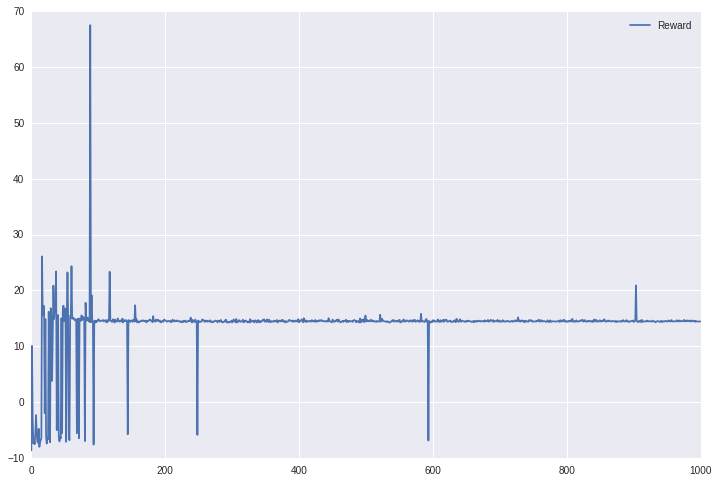

In [18]:
plt.figure(figsize=(12, 8))

plt.plot(total_rewards[0:1000], label='Reward')
plt.legend()

In [ ]:
plt.figure(figsize=(12, 12))
sns.jointplot(np.array(iterations_needed), np.array(total_rewards))

0 200 500 1150 2200